In [1]:
import sys
sys.path.append('..')
import sklearn
from tsai.basics import *
from swdf.losses import *
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback


In [2]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_solfsmy = yaml2dict('./config/solfsmy.yaml', attrdict=True)
config_solfsmy = config_solfsmy.train
# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base, **config_solfsmy})
# Add the architecture config
if config.arch_name.lower() == 'patchtst':
    config.arch = yaml2dict('./config/patchtst.yaml', attrdict=True)
else:
    config.arch = AttrDict()
config

```json
{ 'add_time_channels': False,
  'arch': { 'decomposition': True,
            'individual': True,
            'padding_patch': True,
            'revin': True},
  'arch_config_file': 'config/patchtst.yaml',
  'arch_name': 'PatchTST',
  'bs': 32,
  'data_columns_fcst': ['F10', 'S10', 'M10', 'Y10'],
  'data_path': '../data/SOLFSMY.TXT',
  'data_url': 'https://sol.spacenvironment.net/jb2008/indices/SOLFSMY.TXT',
  'horizon': 6,
  'init_weights': False,
  'lookback': 36,
  'lr_max': None,
  'n_epoch': 30,
  'partial_n': 0.1,
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [3]:
X = load_object("tmp/data/X_values.pkl")
y = load_object("tmp/data/y_values.pkl")
splits = load_object("tmp/data/splits.pkl")

ranges = load_object("tmp/loss_param/ranges.pkl")
solact_distribution = load_object("tmp/loss_param/solact_distribution.pkl")

preproc_pipe = load_object("tmp/pipes/preproc_pipe.pkl")
exp_pipe = load_object("tmp/pipes/exp_pipe.pkl")

solact_levels = ['F10', 'S10', 'M10', 'Y10']

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss = HubberLoss(ranges, solact_distribution, delta=10.).to(device)
metrics = LossMetrics(loss).metrics()

wandb_callback = WandbCallback(log_preds=False)
cbs = L(wandb_callback) if config.wandb.enabled else L()
learn_wMSE = TSForecaster(X, y, splits=splits, batch_size=config.bs,
                     pipelines=[preproc_pipe, exp_pipe], 
                     arch=config.arch_name, 
                     metrics=metrics,
                     loss_func=loss,
                     arch_config=dict(config.arch), 
                     init=config.init_weights,
                     cbs= cbs + ShowGraphCallback(), 
                     partial_n=config.partial_n)
lr_max = learn_wMSE.lr_find().valley if config.lr_max is None else config.lr_max

learn_wMSE.fit_one_cycle(n_epoch=config.n_epoch, lr_max=config.lr_max)
print(f"#params: {sum(p.numel() for p in learn_wMSE.model.parameters())}") 

TypeError: HubberLoss.__init__() got multiple values for argument 'delta'

epoch,train_loss,valid_loss,avg_count_low,avg_count_moderate,avg_count_elevated,avg_count_high,time
0,205.695801,224.925522,28.945970,43.280779,20.662533,0.000000,00:00
1,172.007706,224.365952,25.012400,35.926484,18.224978,0.000000,00:00
2,154.520477,308.558624,35.720992,41.843224,18.253322,0.000000,00:00
3,161.978989,252.091309,27.957484,37.777679,20.407440,0.000000,00:00
4,163.337418,337.072418,29.320638,39.512843,25.679362,0.000000,00:00
5,163.476013,244.398392,28.277236,36.659876,17.459699,0.000000,00:00
6,161.764313,509.675049,30.342781,44.665190,37.186891,0.000000,00:00
7,157.552032,266.052948,35.649247,38.773251,13.831709,0.000000,00:00
8,168.583984,252.537064,22.849424,43.911426,29.165633,0.000000,00:00
9,177.792862,549.360657,44.935341,48.726306,24.205492,0.000000,00:00


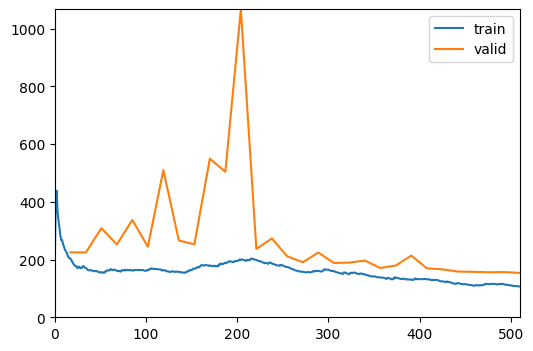

#params: 12729412


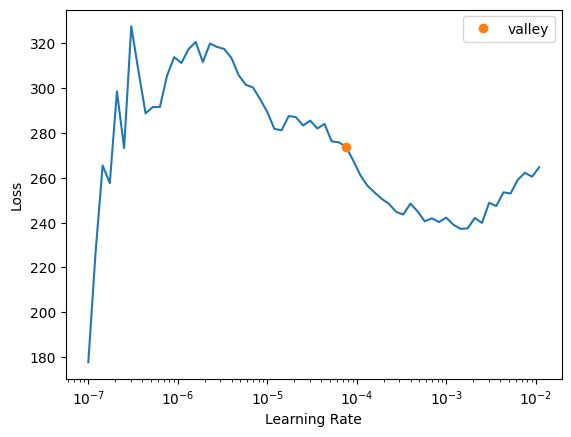

In [ ]:
loss = wMSLELoss(ranges,).to(device)
metrics = LossMetrics(loss).metrics()

learn_wMAE = TSForecaster(X, y, splits=splits, batch_size=config.bs,
                     pipelines=[preproc_pipe, exp_pipe], 
                     arch=config.arch_name, 
                     metrics=metrics,
                     loss_func=loss,
                     arch_config=dict(config.arch), 
                     init=config.init_weights,
                     cbs= cbs + ShowGraphCallback(), 
                     partial_n=config.partial_n)
lr_max = learn_wMAE.lr_find().valley if config.lr_max is None else config.lr_max

learn_wMAE.fit_one_cycle(n_epoch=config.n_epoch, lr_max=config.lr_max)
print(f"#params: {sum(p.numel() for p in learn_wMAE.model.parameters())}")

In [ ]:
# Print the validation loss and save it in case other notebooks (optuna) wants to
# use it for hyperparameter optimization
valid_loss = (learn_wMSE.validate()[0] + learn_wMAE.validate()[0]) / 2
print(valid_loss)
%store valid_loss

78.25165903568268
Stored 'valid_loss' (float)


In [ ]:
# Log the test loss to wandb
test_loss = (learn_wMSE.validate(ds_idx=2)[0] + learn_wMAE.validate(ds_idx=2)[0]) / 2
print(test_loss)

47.352757692337036


In [ ]:
# Save everything
learn_wMAE.dls.loaders += [learn_wMAE.dls.valid.new_dl(X[splits[2]], y[splits[2]])] # Add test datalaoder

# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn_wMAE.remove_cb(wandb_callback)

# Save locally and in wandb if online and enabled
learn_wMAE.save_all(path='tmp', verbose=True, model_fname="model_wMAE", learner_fname="learner_wMAE") 
learn_wMSE.save_all(path='tmp', verbose=True, model_fname="model_wMSE", learner_fname="learner_wMSE") 

Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model_wMAE.pth'
learner_fname = 'learner_wMAE.pkl'
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth']'
model_fname   = 'model_wMSE.pth'
learner_fname = 'learner_wMSE.pkl'
